<h1> Classification d'abeilles </h1>



## Chargement des données

In [1]:
import torch
import os
os.environ["KERAS_BACKEND"] = "torch"
os.environ["CUDA_VISIBLE_DEVICES"]="0" # first gpu
import keras
keras.backend.set_image_data_format("channels_first")

torch.cuda.empty_cache()

In [2]:
if torch.cuda.is_available():
    # Proceed with CUDA operations
    print("available CUDA devices: ", torch.cuda.device_count())
else:
    print("CUDA not available. Using CPU...")

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# tensor = torch.tensor(data, device=device)

available CUDA devices:  1


### test

In [3]:
# Paramètres
IMG_SIZE = 320 # pour utiliser ResNet

In [4]:
train_dir = "/mnt/disk1/datasets/Projet_Bees_Detection_Basile/data_bees_detection/BD307/BD_307_cropped/dataset/train/"
val_dir = "/mnt/disk1/datasets/Projet_Bees_Detection_Basile/data_bees_detection/BD307/BD_307_cropped/dataset/val/"

Feature batch shape: torch.Size([16, 3, 320, 320])
Labels batch shape: torch.Size([16, 306])


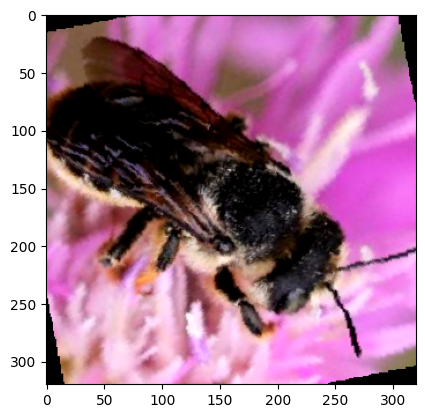

Label: Lithurgus chrysurus


In [5]:
# import os
import glob
# import cv2


import os
import pandas as pd
import matplotlib.pyplot as plt
from torchvision.io import read_image
from torchvision.transforms import v2
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import numpy as np

class CustomImageDataset(Dataset):
    def __init__(self, class_folders_dir, transform=None, target_transform=None):
        self.img_dir = glob.glob(os.path.join(class_folders_dir, "*/*"))
        labels = [img.split("/")[-2] for img in self.img_dir]
        self.class_names = sorted(set(labels))
        self.nb_classes = len(self.class_names)
        self.img_labels = [self.class_names.index(l) for l in labels]
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_dir[idx]
        image = read_image(img_path)
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        # label = np.expand_dims(label,-1)
        # make label hot one vector
        label = torch.nn.functional.one_hot(torch.as_tensor(label), num_classes=self.nb_classes)
        return image, label

augmentations = v2.Compose([
    v2.Resize((IMG_SIZE, IMG_SIZE)),
    v2.RandomRotation(degrees=10),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomAffine(degrees=(-10,10), translate=(0, 0), scale=(0.9, 1.1)),
    v2.ColorJitter(brightness=0, contrast=0.5, saturation=0, hue=0),
    v2.ToDtype(torch.float32),
    v2.Normalize(mean=[0], std=[255]),
    # v2.ToTensor()
    # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

normalize = v2.Compose([
    v2.Resize((IMG_SIZE, IMG_SIZE)),
    v2.ToDtype(torch.float32),
    v2.Normalize(mean=[0], std=[255]),
    # v2.ToTensor()
    # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

training_data = CustomImageDataset(train_dir, augmentations)#, augmentations)
train_dataloader = DataLoader(training_data, batch_size=16, shuffle=True)
class_names = training_data.class_names
nb_classes = len(class_names)

validation_data = CustomImageDataset(val_dir, normalize)
val_dataloader = DataLoader(validation_data, batch_size=16, shuffle=True)

train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0].numpy().argmax()
# plt.imshow(img, cmap="gray")
plt.imshow(img.permute(1, 2, 0), cmap="gray")
plt.show()
print(f"Label: {training_data.class_names[label]}")





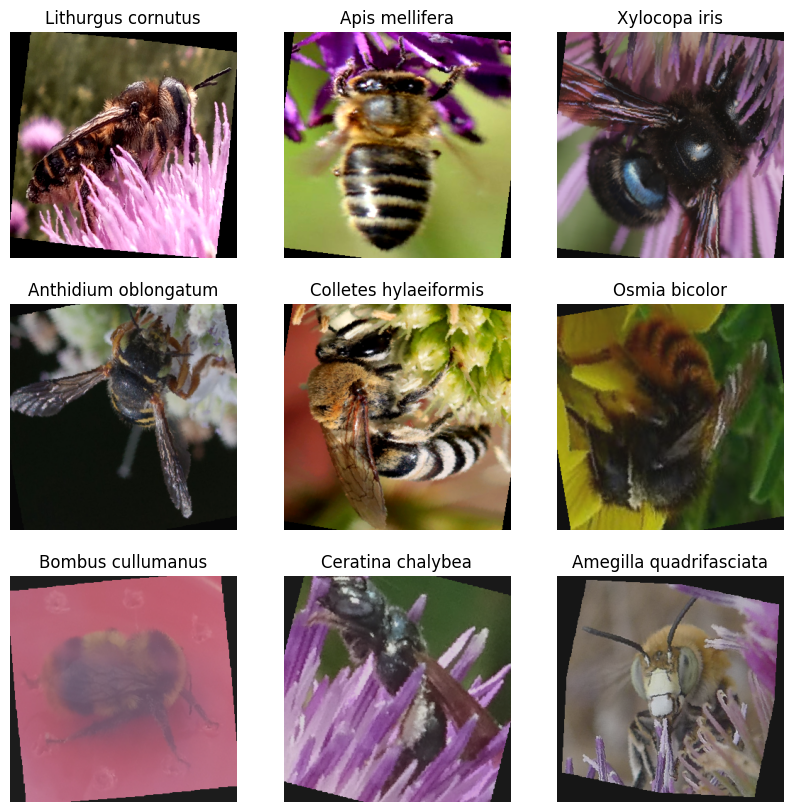

In [6]:
import matplotlib.pyplot as plt

image_batch, label_batch = next(iter(train_dataloader))
label_batch = label_batch.numpy()
# label_batch = label_batch.argmax(axis=1)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("float32").transpose(1, 2, 0))
  label = label_batch[i].argmax()
  plt.title(class_names[label])
  plt.axis("off")


In [7]:
from keras import layers
from keras import regularizers

conv_base = keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(3, IMG_SIZE, IMG_SIZE),
    pooling=None,
    classes=nb_classes
)


# conv_base = K.keras.applications.resnet.ResNet101(
#     include_top=False,
#     weights='imagenet',
#     input_tensor=None,
#     input_shape=(IMG_SIZE, IMG_SIZE, 3),
#     pooling=None,
#     classes=nb_classes,
# )

# conv_base = K.keras.applications.EfficientNetB0(
#     include_top=False,
#     weights="imagenet",
#     input_tensor=None,
#     input_shape=(IMG_SIZE, IMG_SIZE, 3),
#     pooling=None,
#     classes=nb_classes
# )

# conv_base = tf.keras.applications.mobilenet.MobileNet(
#     input_shape=(IMG_SIZE, IMG_SIZE, 3),
#     include_top=False,
#     weights='imagenet',
#     input_tensor=None,
#     pooling=None,
#     classes=nb_classes
# )


inputs = keras.Input(shape=(3, IMG_SIZE, IMG_SIZE))
x = conv_base(inputs)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(nb_classes, kernel_regularizer=regularizers.L2(1e-4), activation='softmax')(x)
model = keras.Model(inputs=inputs, outputs=outputs, name="bee_classifier")

model.summary()

# model = model.to(memory_format=torch.channels_last)
# model.summary()

Model: "bee_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 3, 320, 320)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 2048, 10, 10)   │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 306)            │       626,994 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,214,706 (92.37 MB)

 Trainable params: 24,161,586 (92.17 MB)

 Non-trainable params: 53,120 (207.50 KB)

### end of test

### Poids INat2021

In [8]:
# from tensorflow import keras
# conv_base = keras.models.load_model('drive/MyDrive/Stage2A/INat2021/2623871_resnet50_simclr_v1_inat20_no_top.h5')

# model = keras.Sequential(
#     [
#         conv_base,
#         layers.Dense(nb_classes, kernel_regularizer=regularizers.L2(1e-4), activation='softmax')
#     ]
# )

In [9]:
# model.summary()

## Hierarchical loss

In [10]:
import pandas as pd
import numpy as np

hierarchy_csv = "/home/eremy/Documents/CODE/bound_v1/dataset_analysis/306_hierarchy.csv"
hierarchy = pd.read_csv(hierarchy_csv)

specie = list(hierarchy["specie"].unique())
nb_specie = len(specie)

genus = list(hierarchy["genus"].unique())
nb_genus = len(genus)

family = list(hierarchy["family"].unique())
nb_family = len(family)

order = list(hierarchy["order"].unique())
nb_order = len(order)

class_ = list(hierarchy["class"].unique())
nb_class = len(class_)

species_to_genus = np.zeros((nb_genus, nb_specie))
genus_to_family = np.zeros((nb_family, nb_genus))
family_to_order = np.zeros((nb_order, nb_family))
order_to_class = np.zeros((nb_class, nb_order))

for i in range(nb_specie):
  # specie -> genus
  genus_species = hierarchy.at[i, "genus"]
  ind_genus = genus.index(genus_species)
  species_to_genus[ind_genus, i] = 1

  # genus -> family
  family_species = hierarchy.at[i, "family"]
  ind_family = family.index(family_species)
  genus_to_family[ind_family, ind_genus] = 1

  # family -> order
  order_species = hierarchy.at[i, "order"]
  ind_order = order.index(order_species)
  family_to_order[ind_order, ind_family] = 1

  # order -> class
  class_species = hierarchy.at[i, "class"]
  ind_class = class_.index(class_species)
  order_to_class[ind_class, ind_order] = 1

In [11]:
from numpy.ma.core import transpose
from keras import backend as K
import math

categorical_crossentropy = keras.losses.CategoricalCrossentropy()
# categorical_crossentropy = torch.nn.CrossEntropyLoss(reduction='mean') # FIXME
alpha = 0.5
weight0 = math.exp(-alpha * 0)
weight1 = math.exp(-alpha * 1)
weight2 = math.exp(-alpha * 2)
weight3 = math.exp(-alpha * 3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
species_to_genus = torch.tensor(species_to_genus, dtype=torch.float32).to(device)
genus_to_family = torch.tensor(genus_to_family, dtype=torch.float32).to(device)
family_to_order = torch.tensor(family_to_order, dtype=torch.float32).to(device)


# Définition de la fonction de perte
def Hierarchicaloss(specie_to_genus, genus_to_family, family_to_order, batch_size, alpha=0.1):

    # def weight(height=1):
    #   return math.exp(-alpha * height)
    
    def specie_loss(y_true, y_pred):
      # height = 0
      return weight0 * categorical_crossentropy(y_true, y_pred)
  
    def specie_to_genus_loss(y_true, y_pred):
      # height = 1
      # y_true_genus = K.transpose(K.raw_ops.MatMul(a=specie_to_genus, b=K.cast(y_true, K.float64), transpose_b=True))
      # y_pred_genus = K.transpose(K.raw_ops.MatMul(a=specie_to_genus, b=K.cast(y_pred, K.float64), transpose_b=True))
      y_true_genus = (specie_to_genus.unsqueeze(0) @ y_true.unsqueeze(-1)).mT
      y_pred_genus = (specie_to_genus.unsqueeze(0) @ y_pred.unsqueeze(-1)).mT
      return weight1 * categorical_crossentropy(y_true_genus, y_pred_genus), y_true_genus, y_pred_genus
    
    def genus_to_family_loss(y_true, y_pred):
      # height = 2
      y_true_family = (genus_to_family.unsqueeze(0) @ y_true.unsqueeze(-1)).mT
      y_pred_family = (genus_to_family.unsqueeze(0) @ y_pred.unsqueeze(-1)).mT
      # y_true_family = K.transpose(K.raw_ops.MatMul(a=genus_to_family, b=y_true, transpose_b=True))
      # y_pred_family = K.transpose(K.raw_ops.MatMul(a=genus_to_family, b=y_pred, transpose_b=True))
      return weight2 * categorical_crossentropy(y_true_family, y_pred_family), y_true_family, y_pred_family
    
    def family_to_order_loss(y_true, y_pred):
      # height = 3
      y_true_order = (family_to_order.unsqueeze(0) @ y_true.unsqueeze(-1)).mT
      y_pred_order = (family_to_order.unsqueeze(0) @ y_pred.unsqueeze(-1)).mT
      # y_true_order = K.transpose(K.raw_ops.MatMul(a=family_to_order, b=y_true, transpose_b=True))
      # y_pred_order = K.transpose(K.raw_ops.MatMul(a=family_to_order, b=y_pred, transpose_b=True))
      return weight3 * categorical_crossentropy(y_true_order, y_pred_order)#, y_true_order, y_pred_order

    def HIERARCHICAL_loss(y_true, y_pred):
      loss_specie = specie_loss(y_true, y_pred)
      loss_genus, y_true_genus, y_pred_genus = specie_to_genus_loss(y_true, y_pred)
      loss_family, y_true_family, y_pred_family = genus_to_family_loss(y_true_genus, y_pred_genus)
      # loss_order, y_true_order, y_pred_order = family_to_order_loss(y_true_family, y_pred_family)
      loss_order = family_to_order_loss(y_true_family, y_pred_family)

      return (loss_specie + loss_genus + loss_family + loss_order)/batch_size
   
    # Return a function
    return HIERARCHICAL_loss

In [12]:
hierarchy_loss=[Hierarchicaloss(species_to_genus, genus_to_family, family_to_order, batch_size=16, alpha=0.5)]

## Entraînement du modèle

In [13]:
from keras import optimizers

# Ajout de l'optimiseur, de la fonction coût et des métriques
lr = 1e-3
model.compile(optimizers.SGD(learning_rate=lr, momentum=0.9), loss=hierarchy_loss, metrics=['categorical_accuracy'])#, keras.metrics.Precision(), keras.metrics.Recall()])

In [14]:
# Les callbacks
model_checkpoint_cb = keras.callbacks.ModelCheckpoint(
    filepath='./ResNet.weights.h5',
    save_weights_only=True,
    monitor='val_categorical_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

#early_stopping_cb = tf.keras.callbacks.EarlyStopping(
#    monitor="val_categorical_accuracy",
#    min_delta=0.01,
#    patience=8,
#    verbose=1,
#    mode="auto")
reduce_lr_cb = keras.callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.1,
                              patience=5, min_lr=0.00001, verbose=1)

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# train_dataloader = train_dataloader.to(device)
# val_dataloader = val_dataloader.to(device)
image_batch, label_batch = next(iter(train_dataloader))
print(image_batch.shape, label_batch.shape)
history = model.fit(train_dataloader, epochs=100, validation_data=val_dataloader, callbacks=[model_checkpoint_cb, reduce_lr_cb])


torch.Size([16, 3, 320, 320]) torch.Size([16, 306])
Epoch 1/100


/home/eremy/miniconda3/envs/torch/lib/python3.12/site-packages/keras/src/losses/losses.py:22: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=torch.Size([16, 1, 1, 1, 1]). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


5211/5211 ━━━━━━━━━━━━━━━━━━━━ 0s 776ms/step - categorical_accuracy: 0.2372 - loss: 0.4595

/home/eremy/miniconda3/envs/torch/lib/python3.12/site-packages/keras/src/losses/losses.py:22: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=torch.Size([3, 1, 1, 1, 1]). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)



Epoch 1: val_categorical_accuracy improved from -inf to 0.33277, saving model to ./ResNet.weights.h5


/home/eremy/miniconda3/envs/torch/lib/python3.12/site-packages/keras/src/losses/losses.py:22: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=torch.Size([11, 1, 1, 1, 1]). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


5211/5211 ━━━━━━━━━━━━━━━━━━━━ 4267s 819ms/step - categorical_accuracy: 0.2372 - loss: 0.4594 - val_categorical_accuracy: 0.3328 - val_loss: 0.3502 - learning_rate: 0.0010
Epoch 2/100
5211/5211 ━━━━━━━━━━━━━━━━━━━━ 0s 618ms/step - categorical_accuracy: 0.3572 - loss: 0.3351
Epoch 2: val_categorical_accuracy improved from 0.33277 to 0.43422, saving model to ./ResNet.weights.h5
5211/5211 ━━━━━━━━━━━━━━━━━━━━ 3359s 645ms/step - categorical_accuracy: 0.3572 - loss: 0.3351 - val_categorical_accuracy: 0.4342 - val_loss: 0.2752 - learning_rate: 0.0010
Epoch 3/100
5211/5211 ━━━━━━━━━━━━━━━━━━━━ 0s 600ms/step - categorical_accuracy: 0.4431 - loss: 0.2735
Epoch 3: val_categorical_accuracy improved from 0.43422 to 0.50792, saving model to ./ResNet.weights.h5
5211/5211 ━━━━━━━━━━━━━━━━━━━━ 3263s 626ms/step - categorical_accuracy: 0.4431 - loss: 0.2735 - val_categorical_accuracy: 0.5079 - val_loss: 0.2315 - learning_rate: 0.0010
Epoch 4/100
5211/5211 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - categorical